In [1]:
# ===== 配置 =====
train_dir = '/mnt/sda/sijiali/DataSet/Harvard-GF/Dataset/Training'  # 用哪个集合都行
modality_type = 'rnflt'
task = 'tds'
resolution = 224
depth = 3

# 要对齐检查的 transforms（和训练一致）
transform_names = ['none', 'vit', 'cnn', 'albumentations', 'imagenet']

# 取前多少个样本做对比
max_show = 3

# 可视化
figsize = (16, 3)


In [2]:
import os
from pathlib import Path
from typing import Dict, Any, List, Optional

import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

from utils import (
    get_vit_transform, get_cnn_transform, get_albumentations_transform, get_imagenet_transform
)
from dataset import get_dataloader_HGF


/mnt/sda/sijiali/anaconda3/envs/glaucoma/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def to_hwc_no_scale(x):
    """仅做维度变换以便 imshow；不做任何缩放/归一化/裁剪。"""
    if isinstance(x, torch.Tensor):
        t = x.detach().cpu()
        if t.dim() == 4:  # (B,C,H,W) -> (C,H,W)
            t = t[0]
        if t.dim() == 3 and t.shape[0] in (1,3):
            return t.permute(1,2,0).numpy()
        return t.numpy()
    a = np.asarray(x)
    if a.ndim == 3 and a.shape[0] in (1,3) and a.shape[-1] not in (1,3):
        a = np.transpose(a, (1,2,0))
    return a

def stats_of(x, name: str) -> Dict[str, Any]:
    a = x.detach().cpu().numpy() if isinstance(x, torch.Tensor) else np.asarray(x)
    return dict(name=name, shape=tuple(a.shape), dtype=str(a.dtype),
                min=float(a.min()), max=float(a.max()),
                mean=float(a.mean()), std=float(a.std()))

def get_transform_by_name(name: str, img_size: int):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    if name == 'vit':
        return get_vit_transform(img_size)
    if name == 'cnn':
        return get_cnn_transform(img_size, mean, std)
    if name == 'albumentations':
        return get_albumentations_transform(img_size)
    if name == 'imagenet':
        return get_imagenet_transform(img_size)
    if name == 'none':
        return None
    raise ValueError(f'Unknown transform: {name}')

def show_row(images, titles, figsize=(16,3)):
    fig, axes = plt.subplots(1, len(images), figsize=figsize)
    if len(images) == 1: axes = [axes]
    for ax, im, tt in zip(axes, images, titles):
        ax.axis('off'); ax.set_title(tt)
        if im.ndim == 2 or (im.ndim == 3 and im.shape[-1] == 1):
            ax.imshow(im.squeeze(), cmap='gray')
        else:
            ax.imshow(im)
    plt.tight_layout(); plt.show()

def load_raw_image_from_npz(npz_path: str):
    """尽量从 npz 里取原始 RNFLT 图像（不经过任何 transform）。"""
    raw = np.load(npz_path, allow_pickle=True)
    keys = list(raw.files)
    for k in ['rnflt', 'image', 'img']:
        if k in keys:
            return raw[k], k
    # 否则找第一个 2D/3D 数组
    for k in keys:
        arr = raw[k]
        if isinstance(arr, np.ndarray) and arr.ndim in (2,3):
            return arr, k
    raise KeyError(f'No 2D/3D array in {npz_path}, keys={keys}')


In [4]:
# 为每个 transform 构建一个 DataLoader；batch_size=1，shuffle=False，确保样本顺序可对齐
loaders = {}
files_list = None  # 记录同一顺序的文件（ID）列表，保证对齐

for name in transform_names:
    tfm = get_transform_by_name(name, resolution)
    loader = get_dataloader_HGF(
        data_dir=train_dir,
        modality_type=modality_type,
        task=task,
        resolution=resolution,
        depth=depth,
        transform=tfm,
        batch_size=1,
        shuffle=False,
        num_workers=0,
    )
    loaders[name] = loader
    # 第一次拿到文件顺序（依赖你 dataloader/dataset 的实现，有可能是 Dataset.files）
    if files_list is None and hasattr(loader.dataset, 'files'):
        files_list = list(loader.dataset.files)

assert files_list is not None and len(files_list) > 0, "无法从 DataLoader 拿到样本文件列表（dataset.files）。"
print(f"[INFO] total samples = {len(files_list)}; will show first {max_show}")


[INFO] total samples = 2100; will show first 3



== Sample[0] sid=data_1877 | npz key=rnflt ==
[Original] {'name': 'original', 'shape': (200, 200), 'dtype': 'float64', 'min': -2.0, 'max': 217.00833, 'mean': 72.9201956995, 'std': 44.450184443073546}
[Transform:none] {'name': 'none', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': -2.0, 'max': 216.32131958007812, 'mean': 72.91230773925781, 'std': 44.240665435791016}
[Transform:vit] {'name': 'vit', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': 0.0, 'max': 0.848318874835968, 'mean': 0.2861732542514801, 'std': 0.17308805882930756}
[Transform:cnn] {'name': 'cnn', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': -10.964285850524902, 'max': 963.6844482421875, 'mean': 320.6640930175781, 'std': 195.8070068359375}
[Transform:albumentations] {'name': 'albumentations', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': 0.0, 'max': 0.003921568859368563, 'mean': 0.0036622630432248116, 'std': 0.0009744659764692187}
[Transform:imagenet] {'name': 'imagenet', 'shape': (3, 224, 224), 'dtype':

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..216.32132].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.964286..963.68445].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9658618].


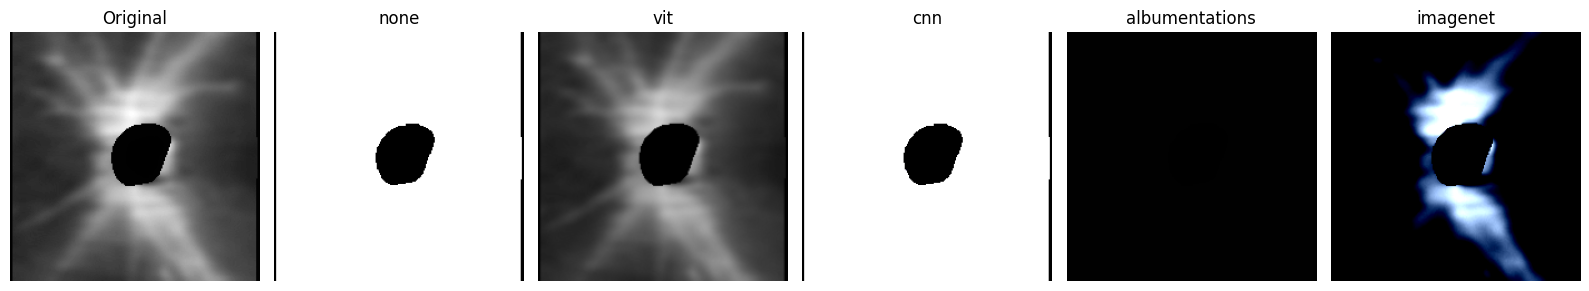


== Sample[1] sid=data_0271 | npz key=rnflt ==
[Original] {'name': 'original', 'shape': (200, 200), 'dtype': 'float64', 'min': -2.0, 'max': 265.88408, 'mean': 83.93344262275, 'std': 52.11745888259958}
[Transform:none] {'name': 'none', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': -2.0, 'max': 264.8211669921875, 'mean': 83.91915893554688, 'std': 51.76021194458008}
[Transform:vit] {'name': 'vit', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': 0.0, 'max': 1.0, 'mean': 0.3293933868408203, 'std': 0.20239341259002686}
[Transform:cnn] {'name': 'cnn', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': -10.964285850524902, 'max': 1180.20166015625, 'mean': 369.37139892578125, 'std': 229.08700561523438}
[Transform:albumentations] {'name': 'albumentations', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': 0.0, 'max': 0.003921568859368563, 'mean': 0.003589513013139367, 'std': 0.0010916980681940913}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..264.82117].


[Transform:imagenet] {'name': 'imagenet', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': -2.1179039478302, 'max': 2.640000104904175, 'mean': -0.5283957123756409, 'std': 0.9066728353500366}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.964286..1180.2017].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


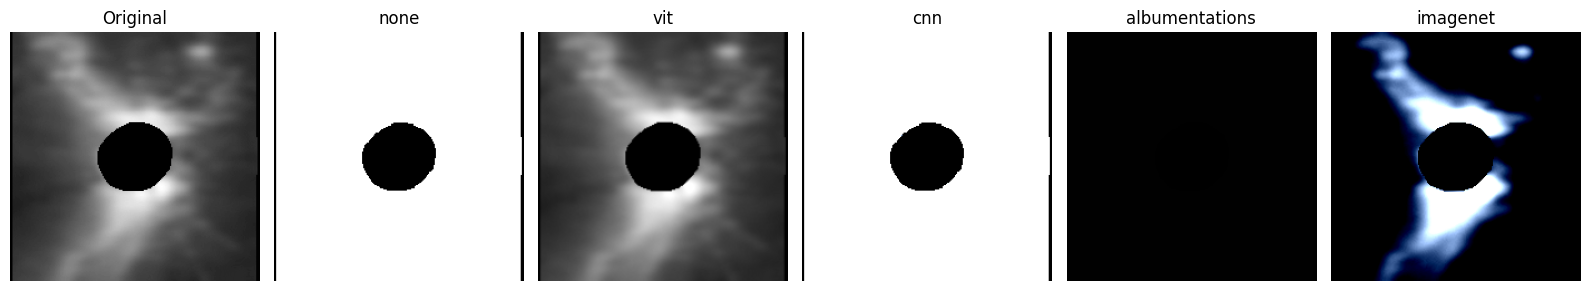


== Sample[2] sid=data_1501 | npz key=rnflt ==
[Original] {'name': 'original', 'shape': (200, 200), 'dtype': 'float64', 'min': -2.0, 'max': 228.73851000000002, 'mean': 70.37594113475001, 'std': 41.68350031821451}
[Transform:none] {'name': 'none', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': -2.0, 'max': 228.4710693359375, 'mean': 70.36536407470703, 'std': 41.42257308959961}
[Transform:vit] {'name': 'vit', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': 0.0, 'max': 0.8959649801254272, 'mean': 0.27614760398864746, 'std': 0.16208918392658234}
[Transform:cnn] {'name': 'cnn', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': -10.964285850524902, 'max': 1017.9244384765625, 'mean': 309.3934631347656, 'std': 183.33578491210938}
[Transform:albumentations] {'name': 'albumentations', 'shape': (3, 224, 224), 'dtype': 'float32', 'min': 0.0, 'max': 0.003921568859368563, 'mean': 0.0036752091255038977, 'std': 0.0009514921111986041}
[Transform:imagenet] {'name': 'imagenet', 'shape': (3, 224, 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0..228.47107].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-10.964286..1017.92444].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1776223].


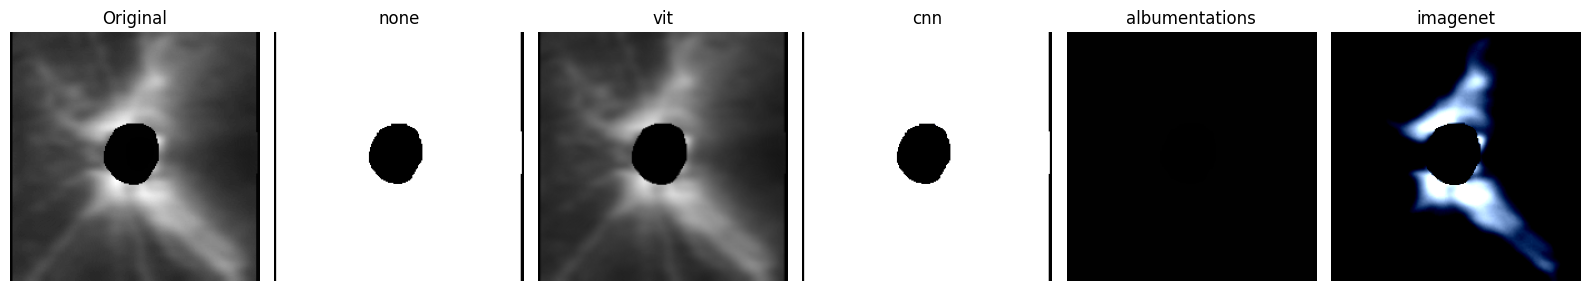


=== Summary stats (grouped by sid) ===

--- Sample: data_0271 ---
          name         shape   dtype        min         max       mean        std
          none (3, 224, 224) float32  -2.000000  264.821167  83.919159  51.760212
           vit (3, 224, 224) float32   0.000000    1.000000   0.329393   0.202393
           cnn (3, 224, 224) float32 -10.964286 1180.201660 369.371399 229.087006
albumentations (3, 224, 224) float32   0.000000    0.003922   0.003590   0.001092
      imagenet (3, 224, 224) float32  -2.117904    2.640000  -0.528396   0.906673

--- Sample: data_1501 ---
          name         shape   dtype        min         max       mean        std
          none (3, 224, 224) float32  -2.000000  228.471069  70.365364  41.422573
           vit (3, 224, 224) float32   0.000000    0.895965   0.276148   0.162089
           cnn (3, 224, 224) float32 -10.964286 1017.924438 309.393463 183.335785
albumentations (3, 224, 224) float32   0.000000    0.003922   0.003675   0.000951
    

In [5]:
# 只看前 max_show 个样本
all_stats = []

for idx in range(min(max_show, len(files_list))):
    # 从文件名拿 ID（不含扩展名）
    npz_name = Path(files_list[idx]).name
    sid = Path(npz_name).stem
    npz_path = os.path.join(train_dir, npz_name)

    # ---- 原图（从 npz 直接读）----
    raw_img, raw_key = load_raw_image_from_npz(npz_path)
    print(f"\n== Sample[{idx}] sid={sid} | npz key={raw_key} ==")
    print("[Original]", stats_of(raw_img, "original"))

    # 一行可视化：原图 + 各 transform 后
    images = [to_hwc_no_scale(raw_img)]
    titles = ["Original"]

    # ---- 各 transform 的 DataLoader 上，取相同 idx 的样本 ----
    for name, loader in loaders.items():
        sample = loader.dataset[idx]           # Dataset 的 __getitem__（transform 已应用）
        timg   = sample['image']               # transform 后的图

        st = stats_of(timg, name)              # 统计 transform 后
        all_stats.append({'sid': sid, **st})
        print(f"[Transform:{name}] {st}")

        images.append(to_hwc_no_scale(timg))   # 只做维度转置，不改像素
        titles.append(name)

    # 可视化一行：原图 + 各 transform 后
    show_row(images, titles, figsize=figsize)

# 分组打印：每个样本一张小表（不保存文件）
df_stats = pd.DataFrame(all_stats)
print("\n=== Summary stats (grouped by sid) ===")
for sid, subdf in df_stats.groupby("sid"):
    print(f"\n--- Sample: {sid} ---")
    print(subdf.drop(columns=["sid"]).to_string(index=False))


In [ ]:
from dino_model import DinoV3Backbone52

model = DinoV3Backbone52(
            hf_model_name='/mnt/sda/sijiali/GlaucomaCode/pretrained_weight/dinov3-vitb16-pretrain-lvd1689m',
            out_dim=52,
            apply_imagenet_norm=False,   
            vit_pool="cls"             
        )

from torchinfo import summary as info_summary
info_summary(model, input_size=(1, 3, 224, 224))

/mnt/sda/sijiali/anaconda3/envs/glaucoma/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Layer (type:depth-idx)                             Output Shape              Param #
DinoV3Backbone52                                   [1, 52]                   --
├─DINOv3ViTModel: 1-1                              [1, 768]                  --
│    └─DINOv3ViTEmbeddings: 2-1                    [1, 201, 768]             4,608
│    │    └─Conv2d: 3-1                            [1, 768, 14, 14]          590,592
│    └─DINOv3ViTRopePositionEmbedding: 2-2         [196, 64]                 --
│    └─ModuleList: 2-3                             --                        --
│    │    └─DINOv3ViTLayer: 3-2                    [1, 201, 768]             7,088,640
│    │    └─DINOv3ViTLayer: 3-3                    [1, 201, 768]             7,088,640
│    │    └─DINOv3ViTLayer: 3-4                    [1, 201, 768]             7,088,640
│    │    └─DINOv3ViTLayer: 3-5                    [1, 201, 768]             7,088,640
│    │    └─DINOv3ViTLayer: 3-6                    [1, 201, 768]             7,

: 

In [ ]:
from transformers import pipeline
from transformers.image_utils import load_image

url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/pipeline-cat-chonk.jpeg"
image = load_image(url)

feature_extractor = pipeline(
    model="/mnt/sda/sijiali/GlaucomaCode/pretrained_weight/dinov3-vitb16-pretrain-lvd1689m",
    task="image-feature-extraction", 
)
features = feature_extractor(image)